### Домашнее задание №5 к лекции «Задачи классификации и кластеризации»

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, 
                             roc_curve, auc, silhouette_score)

#### Задание.
1. Возьмите датасет с цветками iris’а (функция load_iris из библиотеки sklearn)  
2. Оставьте два признака - sepal_length и sepal_width и целевую переменную - variety
3. Разделите данные на выборку для обучения и тестирования
4. Постройте модель LDA
5. Визуализируйте предсказания для тестовой выборки и центры классов
6. Отбросьте целевую переменную и оставьте только два признака - sepal_length и sepal_width
7. Подберите оптимальное число кластеров для алгоритма kmeans и визуализируйте полученную кластеризацию

In [2]:
iris = load_iris(as_frame=True)

In [7]:
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['variety'] = iris.target

In [8]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
df['target'].value_counts()

0    50
1    50
2    50
Name: target, dtype: int64

In [9]:
df_1 = df[['sepal length (cm)', 'sepal width (cm)', 'variety']]

In [11]:
df_1.head()

,sepal length (cm),sepal width (cm),variety
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0


In [28]:
X = df[['sepal length (cm)', 'sepal width (cm)']]
y = df['variety']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [31]:
len(y_test)

38

In [32]:
lda = LinearDiscriminantAnalysis()

In [33]:
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [51]:
y_pred = lda.predict(X_test)

In [78]:
y_proba = lda.predict_proba(X_test)
y_proba

array([[1.18640942e-04, 5.71170483e-01, 4.28710876e-01],
       [9.98305477e-01, 1.29689718e-03, 3.97626130e-04],
       [4.65740470e-12, 3.31288153e-02, 9.66871185e-01],
       [9.16238393e-04, 6.25138562e-01, 3.73945200e-01],
       [2.54918739e-07, 2.11414585e-01, 7.88585160e-01],
       [9.78902076e-01, 1.82992290e-02, 2.79869482e-03],
       [2.19308787e-02, 7.89212788e-01, 1.88856333e-01],
       [3.90623726e-06, 1.74836227e-01, 8.25159867e-01],
       [3.44635665e-08, 5.17588278e-01, 4.82411688e-01],
       [4.05227643e-04, 7.26045565e-01, 2.73549208e-01],
       [4.95052155e-04, 3.45611436e-01, 6.53893512e-01],
       [9.70175212e-01, 2.87225421e-02, 1.10224549e-03],
       [9.86427963e-01, 1.13791654e-02, 2.19287163e-03],
       [9.81207135e-01, 1.79260620e-02, 8.66802978e-04],
       [9.99983043e-01, 1.57358477e-05, 1.22072591e-06],
       [9.49906973e-03, 4.50399010e-01, 5.40101920e-01],
       [4.34330666e-05, 3.46712511e-01, 6.53244055e-01],
       [1.71745723e-04, 8.08067

In [52]:
result = pd.DataFrame([np.array(y_test), y_pred]).T

In [113]:
def metrics_dict(y_test, y_pred, y_proba):
    metrics = {}
    metrics['Accuracy'] = (accuracy_score(y_test, y_pred))
    metrics['Precision'] = (precision_score(y_test, y_pred, average='weighted'))
    metrics['Recall'] = (recall_score(y_test, y_pred, average='weighted'))
    metrics['F1'] = (f1_score(y_test, y_pred, average='weighted'))
    metrics['ROC AUC'] = (roc_auc_score(y_test, y_proba, multi_class='ovr'))
    return pd.DataFrame.from_dict(metrics, orient='index', columns=['value'])

In [117]:
def model(df, filtr=None):
    X = df[['sepal length (cm)', 'sepal width (cm)']]
    y = df['variety']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_proba = lda.predict_proba(X_test)
    display(metrics_dict(y_test, y_pred, y_proba))
    plt.scatter(
        x = X_train['sepal length (cm)'],
        y = X_train['sepal width (cm)'], 
        c = y_train)
    plt.scatter(lda.means_[:,0], lda.means_[:,1], c='r', s=100)

,value
Accuracy,0.868421
Precision,0.879605
Recall,0.868421
F1,0.865343
ROC AUC,0.950682


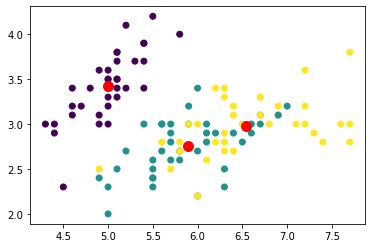

In [118]:
model(df_1)

In [77]:
result.head()

,0,1
0,1,1
1,0,0
2,2,2
3,1,1
4,1,2


In [115]:
metrics_dict(y_test, y_pred, y_proba)

,value
Accuracy,0.868421
Precision,0.879605
Recall,0.868421
F1,0.865343
ROC AUC,0.950682


In [ ]:
pd.DataFrame.from_dict(met, orient='index')

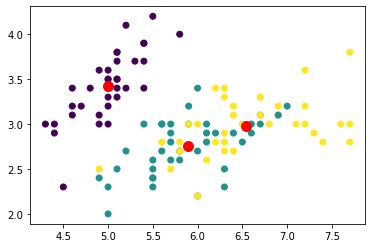

In [103]:
plt.scatter(x = X_train['sepal length (cm)'],
            y = X_train['sepal width (cm)'], 
            c = y_train)
plt.scatter(lda.means_[:,0], lda.means_[:,1], c='r', s=100)

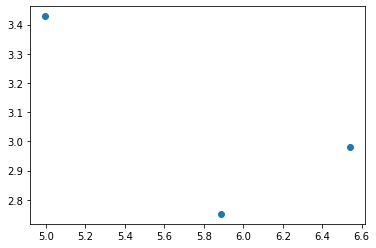

In [101]:
plt.scatter(lda.means_[:,0], lda.means_[:,1])